# Reddit Comment Clustering Using TF-IDF
<img src="https://raw.githubusercontent.com/rosswlewis/RedditComments/master/reddit_log-100011890-large.jpg" align="left" width="35%">

# Here, we import the spark libraries we need and read in the data from Postgres

In [1]:
from pyspark.sql.functions import lower, udf
from pyspark.sql import Row
from pyspark.ml import Pipeline
from pyspark.sql.types import *
from pyspark.ml.clustering import KMeans
from pyspark.ml import PipelineModel
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, HashingTF, IDF, Normalizer

In [2]:
uname = "readonly"
pword = "watson"
dbUrl = "jdbc:postgresql://haproxy635.sl-us-dal-9-portal.2.dblayer.com:10635/compose?user="+uname+"&password="+pword
table = "reddit"
comments = spark.read.format("jdbc").option("url",dbUrl).option("dbtable",table).load()

# To clean the data, we only use comments that haven't been deleted, are over 100 characters long, and we remove punctuation

In [3]:
commentLower = comments.filter("length(body) >= 100").\
    select(lower(comments.body).alias("lowerText")).distinct().repartition(30)

In [4]:
tokenizer = RegexTokenizer().setInputCol("lowerText").setOutputCol("words").setPattern("\\W+")

# There are a lot of words that we don't want to have an affect on clusters.  Here, we prepare a stop word remover for our pipeline. 

In [5]:
additionalWords = ["b","c","d","e","f","g","h","j","k","l","m","n","o","p",
                            "q","r","s","t","u","v","w","x","y","z",
                            "0","1","2","3","4","5","6","7","8","9","10",
                            "oh","wow","stuff","thank","isn","don","didn","people",
                            "thing","ve","time","know","think"]
remover = StopWordsRemover().setInputCol("words").setOutputCol("noStopWords")
currentStopWords = remover.getStopWords()
allStopWords = list(set(currentStopWords) | set(additionalWords))
remover.setStopWords(allStopWords)

StopWordsRemover_4586b4deac04df570630

# Add a column which hashes each individual word to an integer, and mark the frequency of that word in the comment

In [6]:
hashingTF = HashingTF().setInputCol("noStopWords").setOutputCol("hashingTF").setNumFeatures(25000)

# Add a column which looks at all words in all comments and ranks the importance

In [7]:
idf = IDF().setInputCol("hashingTF").setOutputCol("idf")

# Normalize the output

In [8]:
normalizer = Normalizer().setInputCol("idf").setOutputCol("features")

# Based on the important words of different comments, create a pipeline to cluster the comments by topic

In [9]:
kmeans = KMeans().setFeaturesCol("features").setPredictionCol("prediction").setK(250)
pipeline = Pipeline().setStages([tokenizer, remover, hashingTF, idf, normalizer, kmeans])
model = pipeline.fit(commentLower)

In [10]:
predictionsDF = model.transform(commentLower).cache()

<img src="https://raw.githubusercontent.com/rosswlewis/RedditComments/master/TFIDF-FIG-01.JPG" align="left">

In [11]:
userInput = "With my free time, I like to play video games, drum, and do big data analytics."

commentDataFrame = spark.createDataFrame(sc.parallelize([userInput]).map(lambda i: Row(lowerText=i)))

curCom = model.transform(commentDataFrame)

In [12]:
curCom.select("lowerText","prediction").take(1)

[Row(lowerText=u'With my free time, I like to play video games, drum, and do big data analytics.', prediction=195)]

# Let's look at 10 examples from that cluster

In [13]:
predictionsDF.cache()

DataFrame[lowerText: string, words: array<string>, noStopWords: array<string>, hashingTF: vector, idf: vector, features: vector, prediction: int]

In [15]:
for comment in predictionsDF.filter("prediction = 195").limit(10).select("lowerText").collect():
    print comment

Row(lowerText=u"i'm a supervisor and i have a great team of people that require very little supervision or guidance at this point, i just approve their work and play games on my cell phone in the bathroom.  ")
Row(lowerText=u"yessir, most convoluted thing in motorsports as far as driving goes. i haven't competed in full stage rally but i've done rallycross and currently drift. rally is where i'd like to be but it doesn't pay well at all in the u.s. still do it a lot in video games though.")
Row(lowerText=u'console games, unless they suck, take longer to go on sale. the aaa new releases are $60, things a year or two old are $50. used, old games for current gen consoles you rarely see for less than $20 unless they are really horrible.')
Row(lowerText=u"this really gets me, because a lot of companies won't re-release their older games. i know the vc is a thing, but didn't have earthbound until a couple months ago, not to mention that it's 100% impossible to play mother 1 or 3 in english l

# And a wordcloud of that cluster

In [16]:
!pip install wordcloud

In [17]:
%matplotlib inline
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [18]:
cleanUp = udf(lambda s: " ".join(list(s)), StringType())
df = predictionsDF.withColumn('cleanWords', cleanUp(predictionsDF.noStopWords))
df.cache()

DataFrame[lowerText: string, words: array<string>, noStopWords: array<string>, hashingTF: vector, idf: vector, features: vector, prediction: int, cleanWords: string]

(-0.5, 399.5, 199.5, -0.5)

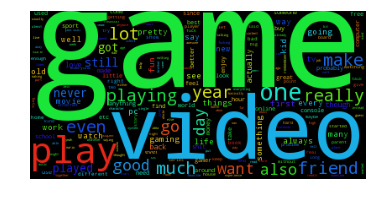

In [19]:
words = " ".join(df.filter("prediction = 195").select("cleanWords").rdd.map(lambda r: r.cleanWords).collect())
wordcloud = WordCloud().generate(words)

plt.imshow(wordcloud)
plt.axis("off")

# Let's look at 10 examples from another cluster

In [27]:
for comment in predictionsDF.filter("prediction = 140").limit(10).select("lowerText").collect():
    print comment

Row(lowerText=u"hillary clinton. bernie sanders is basically the ron paul of this election. he's not going to get anywhere near the nomination. like her or hate her, clinton is a warhorse, and knows the game. ")
Row(lowerText=u'if "nomination" = democratic nomination, then yes, she\'s doing quite well against any current or potential democratic candidates, with a current spread of ~50 points: http://www.realclearpolitics.com/epolls/2016/president/us/2016_democratic_presidential_nomination-3824.html')
Row(lowerText=u'i\'m on board with a lot of what he\'s saying, but i am skeptical that he will be able to win the nomination. i am more optimistic about elizabeth warren, who seems to radiate more "progressive ideas" and less "crotchety grandpa."')
Row(lowerText=u"eck, most likely not.  i just don't have a dog in that race.  maybe if rand paul got the republican nomination, but he wont.  it's going to be jeb and hillary, and i intensely disagree with both of them on just about everything. 

(-0.5, 399.5, 199.5, -0.5)

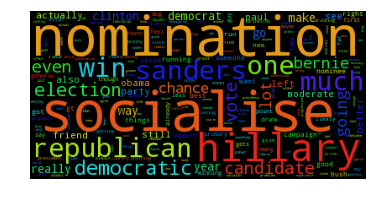

In [29]:
words = " ".join(df.filter("prediction = 140").select("cleanWords").rdd.map(lambda r: r.cleanWords).collect())
wordcloud = WordCloud().generate(words)

plt.imshow(wordcloud)
plt.axis("off")

In [25]:
!pip install --upgrade watson-developer-cloud

Requirement already up-to-date: watson-developer-cloud in /gpfs/global_fs01/sym_shared/YPProdSpark/user/s7b5-a379ff83b58a2d-0170d17c3903/.local/lib/python2.7/site-packages
Requirement already up-to-date: pyOpenSSL>=16.2.0 in /gpfs/global_fs01/sym_shared/YPProdSpark/user/s7b5-a379ff83b58a2d-0170d17c3903/.local/lib/python2.7/site-packages (from watson-developer-cloud)
Requirement already up-to-date: requests<3.0,>=2.0 in /gpfs/global_fs01/sym_shared/YPProdSpark/user/s7b5-a379ff83b58a2d-0170d17c3903/.local/lib/python2.7/site-packages (from watson-developer-cloud)
Requirement already up-to-date: pysolr<4.0,>=3.3 in /gpfs/global_fs01/sym_shared/YPProdSpark/user/s7b5-a379ff83b58a2d-0170d17c3903/.local/lib/python2.7/site-packages (from watson-developer-cloud)
Requirement already up-to-date: cryptography>=1.7 in /gpfs/global_fs01/sym_shared/YPProdSpark/user/s7b5-a379ff83b58a2d-0170d17c3903/.local/lib/python2.7/site-packages (from pyOpenSSL>=16.2.0->watson-developer-cloud)
Requirement already u

In [30]:
from watson_developer_cloud import PersonalityInsightsV3
import json
import pandas as pd
personality_insights = PersonalityInsightsV3(version='2016-10-20',username='bf715692-84c1-48f4-bc9a-0f1e13576c3e',password='GGO2sGkacqAC')

In [31]:
print predictionsDF.filter("prediction = 195").count()
print predictionsDF.filter("prediction = 140").count()

8370
202


In [32]:
gameText = " ".join(predictionsDF.filter("prediction = 195").limit(500).select("lowerText").rdd.map(lambda r: r.lowerText).collect()).encode('utf8')
profile = personality_insights.profile(gameText, 
                                       content_type='text/plain', content_language=None,
                                       accept='application/json', accept_language=None, raw_scores=False,
                                       consumption_preferences=False, csv_headers=False)
gameJson = json.loads(json.dumps(profile, indent=2))
from pprint import pprint
print pprint(gameJson)

{u'needs': [{u'category': u'needs',
             u'name': u'Challenge',
             u'percentile': 0.17080554782765572,
             u'trait_id': u'need_challenge'},
            {u'category': u'needs',
             u'name': u'Closeness',
             u'percentile': 0.010428913026980735,
             u'trait_id': u'need_closeness'},
            {u'category': u'needs',
             u'name': u'Curiosity',
             u'percentile': 0.5179359904452863,
             u'trait_id': u'need_curiosity'},
            {u'category': u'needs',
             u'name': u'Excitement',
             u'percentile': 0.13647133696113234,
             u'trait_id': u'need_excitement'},
            {u'category': u'needs',
             u'name': u'Harmony',
             u'percentile': 0.0014301749879433445,
             u'trait_id': u'need_harmony'},
            {u'category': u'needs',
             u'name': u'Ideal',
             u'percentile': 0.1195214490926017,
             u'trait_id': u'need_ideal'},
       

In [57]:
val = gameJson['needs']
print pd.DataFrame(val, columns=["name", "percentile"])

               name  percentile
0         Challenge    0.172244
1         Closeness    0.011883
2         Curiosity    0.567948
3        Excitement    0.140574
4           Harmony    0.002204
5             Ideal    0.129445
6           Liberty    0.220699
7              Love    0.043180
8      Practicality    0.219860
9   Self-expression    0.060738
10        Stability    0.045473
11        Structure    0.449969


In [33]:
bbqText = " ".join(predictionsDF.filter("prediction = 140").limit(500).select("lowerText").rdd.map(lambda r: r.lowerText).collect()).encode('utf8')
profile = personality_insights.profile(bbqText, 
                                       content_type='text/plain', content_language=None,
                                       accept='application/json', accept_language=None, raw_scores=False,
                                       consumption_preferences=False, csv_headers=False)
bbqJson = json.loads(json.dumps(profile, indent=2))
val = bbqJson['needs']
print pd.DataFrame(val, columns=["name", "percentile"])

               name  percentile
0         Challenge    0.038520
1         Closeness    0.041234
2         Curiosity    0.154926
3        Excitement    0.025511
4           Harmony    0.001910
5             Ideal    0.097516
6           Liberty    0.009013
7              Love    0.024859
8      Practicality    0.046327
9   Self-expression    0.025915
10        Stability    0.018984
11        Structure    0.142272
